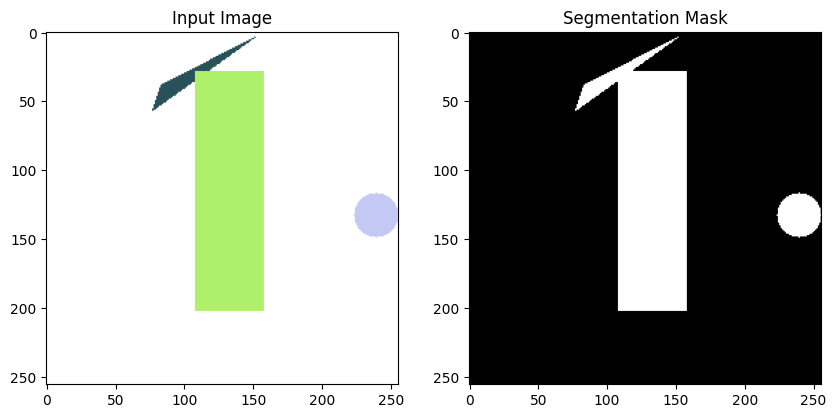

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to generate synthetic images and masks
def generate_synthetic_data(num_images, img_size):
    images = []
    masks = []
    for _ in range(num_images):
        img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # White background image
        mask = np.zeros((img_size, img_size, 1), dtype=np.uint8)

        # Generate random colored shapes
        num_shapes = np.random.randint(3, 6)
        for _ in range(num_shapes):
            shape_type = np.random.choice(['rectangle', 'circle', 'triangle'])
            # Convert color to a tuple of integers
            color = tuple(np.random.randint(0, 255, (3,)).tolist())
            if shape_type == 'rectangle':
                pt1 = tuple(np.random.randint(0, img_size, (2,)))
                pt2 = tuple(np.random.randint(pt1[0], img_size, (2,)))
                cv2.rectangle(img, pt1, pt2, color, -1)
                cv2.rectangle(mask, pt1, pt2, 255, -1)
            elif shape_type == 'circle':
                center = tuple(np.random.randint(0, img_size, (2,)))
                radius = np.random.randint(10, 50)
                cv2.circle(img, center, radius, color, -1) # Pass color as a tuple
                cv2.circle(mask, center, radius, 255, -1)
            elif shape_type == 'triangle':
                pt1 = tuple(np.random.randint(0, img_size, (2,)))
                pt2 = tuple(np.random.randint(0, img_size, (2,)))
                pt3 = tuple(np.random.randint(0, img_size, (2,)))
                points = np.array([pt1, pt2, pt3], np.int32)
                points = points.reshape((-1, 1, 2))
                cv2.fillPoly(img, [points], color)
                cv2.fillPoly(mask, [points], 255)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Generate synthetic dataset
num_images = 1000
img_size = 256
images, masks = generate_synthetic_data(num_images, img_size)

# Display example image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title('Input Image')
plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title('Segmentation Mask')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Function to generate synthetic images and masks (example)
def generate_synthetic_data(num_images, img_size):
    # Example implementation; replace with your own data loading/generation logic
    images = np.random.rand(num_images, img_size, img_size, 3)  # Example random images
    masks = np.random.randint(0, 2, size=(num_images, img_size, img_size, 1))  # Example random masks
    return images, masks

# Define the U-Net model architecture
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom of the U
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expansive Path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = concatenate([up6, drop4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example: Generate synthetic data
num_images = 1000
img_size = 256
images, masks = generate_synthetic_data(num_images, img_size)

# Compile the model
model = unet_model(input_shape=(img_size, img_size, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train the model
history = model.fit(images, masks, batch_size=8, epochs=20, validation_split=0.2)


2024-07-02 14:05:39.256083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 14:05:39.256174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 14:05:39.387761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/20


2024-07-02 14:07:32.493936: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-02 14:07:33.547752: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.053913236s
Trying algorithm eng0{} for conv (f32[64,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-02 14:07:36.262550: E external/

100/100 ━━━━━━━━━━━━━━━━━━━━ 157s 502ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 471ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.5006 - loss: 0.6931 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 473ms/step - accuracy: 0.5008 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 473ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 476ms/step - accuracy: 0.5016 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 475ms/step - accuracy: 0.5019 - loss: 0.6931 - va

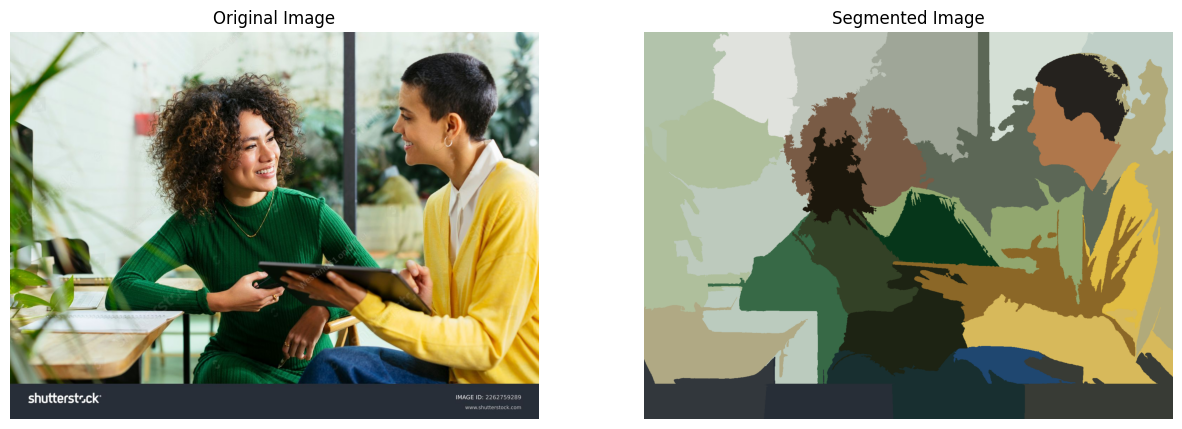

In [8]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread

# Load your own image
image_path = '/content/stock-photo-happy-business-colleagues-having-discussion-over-tablet-pc-2262759289.jpg'  # Replace with your image path
your_image = imread(image_path)

# Setting the plot size
plt.figure(figsize=(15, 15))

# Applying SLIC segmentation
segments = slic(your_image,
                n_segments=50,
                compactness=10)

# Plotting the original image
plt.subplot(1, 2, 1)
plt.imshow(your_image)
plt.title('Original Image')
plt.axis('off')

# Visualizing the segments
plt.subplot(1, 2, 2)
plt.imshow(label2rgb(segments, your_image, kind='avg'))
plt.title('Segmented Image')
plt.axis('off')

plt.show()


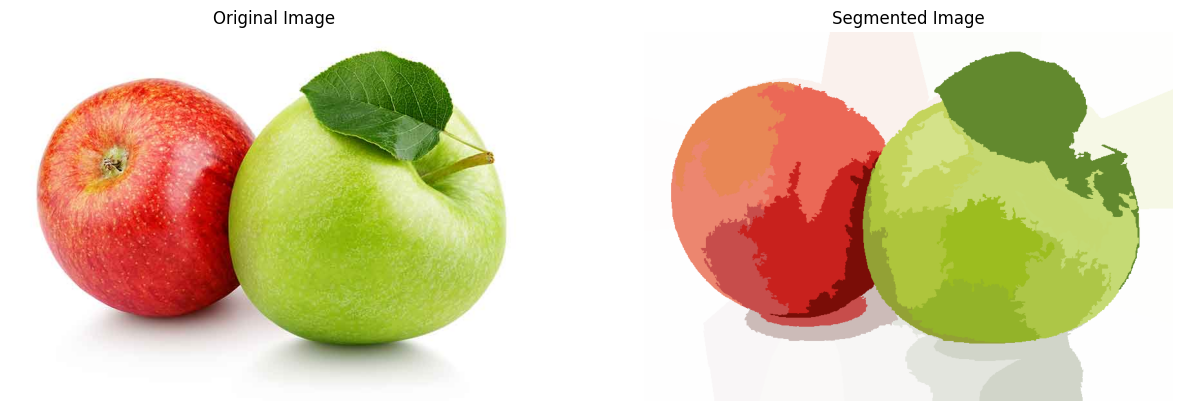

In [1]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread

# Load your own image
image_path = '/content/red-and-green-apples.jpg'  # Replace with your image path
your_image = imread(image_path)

# Setting the plot size
plt.figure(figsize=(15, 15))

# Applying SLIC segmentation
segments = slic(your_image,
                n_segments=50,
                compactness=10)

# Plotting the original image
plt.subplot(1, 2, 1)
plt.imshow(your_image)
plt.title('Original Image')
plt.axis('off')

# Visualizing the segments
plt.subplot(1, 2, 2)
plt.imshow(label2rgb(segments, your_image, kind='avg'))
plt.title('Segmented Image')
plt.axis('off')

plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,ConcatDataset,SubsetRandomSampler
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import cv2
import glob
from torchvision import transforms
import pandas as pd
from torchvision.models.segmentation import fcn_resnet101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
df = pd.read_csv("/content/class_dict.csv")
label_dict = dict()
df
for x,rows in enumerate(df.iterrows()):
    rgb = [rows[1]['r'],rows[1]['g'],rows[1]['b']]
    label_dict[x] = rgb

In [11]:
img = cv2.imread("/content/0001TP_009240.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask = cv2.imread("/content/0001TP_009240_L.png")
mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
print(img .shape)
print(mask.shape)

(720, 960, 3)
(720, 960, 3)


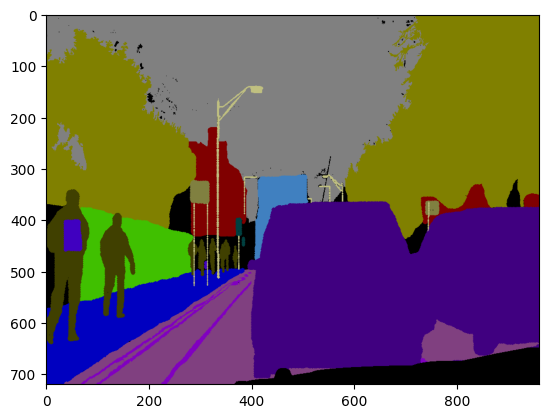

In [12]:
plt.imshow(mask)